In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy import linalg as LA 

In [3]:
# The dpi (dots-per-inch) setting will affect the resolution and how large
#  the plots appear on screen and printed.  So you may want/need to adjust 
#  the figsize when creating the figure.
plt.rcParams['figure.dpi'] = 100.    # this is the default for notebook

# Change the common font size (smaller when higher dpi)
font_size = 10
plt.rcParams.update({'font.size': font_size})

In [4]:
class CoupledOscillators:
    """
    Solve the equations for linear coupled oscillators in matrix formulation.
    """
    
    def __init__(self, M_matrix, K_matrix, b_matrix=np.zeros(1)):
        self.M_matrix = M_matrix
        self.K_matrix = K_matrix
        self.q_len = len(self.M_matrix)
        if b_matrix.any():
            self.b_matrix = b_matrix
        else:    
            self.b_matrix = np.zeros((self.q_len)) 
        self.full_matrix = np.zeros((self.q_len, self.q_len))
        
            
    def dy_dt(self, t, y):
        """
        This function returns the right-hand side of the diffeq: 
        [dq_vec/dt d^2q_vec/dt^2]
        
        Parameters
        ----------
        t : float
            time 
        y : float
            vector with y[:q_len] = q_vec, y[q_len:] = dqvec/dt
            
        """
        dy_dt_vec = np.zeros(2*self.q_len)   # Initialize to twice q_vec size
        # Set the upper half [:self.q_len] of dy_dt to the lower half of y
        dy_dt_vec[:self.q_len] = y[self.q_len:]  
        # Set the lower half [self.q_len:] of dy_dt to the vector that
        #  results from M^{-1} K y where @ is matrix multiplication
        dy_dt_vec[self.q_len:] = -1.* LA.inv(self.M_matrix) @ \
                    ( self.K_matrix @ y[:self.q_len] + \
                      self.b_matrix @ y[self.q_len:] )
        return dy_dt_vec
    
    
    def solve_ode(self, t_pts, q_vec_0, q_vec_dot_0,
                  method='RK45',
                  abserr=1.0e-10, relerr=1.0e-10):
        """
        Solve the ODE given initial conditions.
        Use solve_ivp with the option of specifying the method.
        Specify smaller abserr and relerr to get more precision.
        """
        y = np.concatenate((q_vec_0, q_vec_dot_0))
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, method=method, 
                             atol=abserr, rtol=relerr)
        q_vec, q_vec_dot = np.array_split(solution.y, 2)
        return q_vec, q_vec_dot
    

    def find_eigenmodes(self):
        """
        Find the normal modes.
        """
        eig_vals, eig_vecs = LA.eigh(K_matrix, M_matrix)
        self.frequencies = np.sqrt(eig_vals)
        return eig_vals, eig_vecs
    
    def plot_eigenmodes(self, t_pts, output_file=None):
        """
        plot the normal modes separately
        """
        from itertools import cycle
        colors = ['blue', 'green', 'red', 'purple']

        eig_vals, eig_vecs = self.find_eigenmodes()
        for i in np.arange(self.q_len): 
            q_vec_0 = eig_vecs[:,i]   # this is the i'th eigenvector
            q_vec_dot_0 = np.zeros(self.q_len)  # start with all qdots = 0
            q_vec, q_vec_dot = self.solve_ode(t_pts, q_vec_0, q_vec_dot_0)
             
            fig, axes = plt.subplots(self.q_len, 1, 
                                     figsize=(10, 2.*self.q_len))
            color_list = cycle(colors)
            for j in np.arange(self.q_len):
               axes[j].plot(t_pts, q_vec[j], color=next(color_list))
               axes[j].set_xlabel(r'$t$')
               axes[j].set_ylabel(fr'$q_{j+1:d}$')
               axes[j].axvline(2.*np.pi/np.sqrt(eig_vals[i]), 
                               color='black', linestyle=':')
            overall_title = fr'Normal mode {i+1:d}, ' + \
                            fr'$\omega = {self.frequencies[i]:.2f}$' 
            fig.suptitle(overall_title, va='center')
            fig.tight_layout()
            if output_file:
                 output_file_name = output_file.replace('.', f'_{i:d}.', 1)
                 fig.savefig(output_file_name, dpi=200, bbox_inches='tight')

In [5]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

In [6]:
m1 = 1.
m2 = 1.
L1 = 1.
L2 = 1.
g = 9.8
M_matrix = np.array([ [(m1 + m2) * L1**2, m2 * L1 * L2], [m2 * L1 * L2, m2 * L2**2] ])
print('M matrix: \n', M_matrix, '\n')

k = 1.
K_matrix = np.array([ [(m1 + m2) * g * L1, 0], [0, m2 * g * L2]])
print('K matrix: \n', K_matrix, '\n')

# b = 0
# b_matrix = np.array([ [b, 0], [0, b]])
# print('b matrix: \n', b_matrix, '\n')

co1 = CoupledOscillators(M_matrix, K_matrix)

eig_vals, eig_vecs = co1.find_eigenmodes() # LA.eigh(K_matrix, M_matrix)

print(f'omega^2 = {eig_vals}')
print(f'frequencies = {co1.frequencies}')

M matrix: 
 [[2. 1.]
 [1. 1.]] 

K matrix: 
 [[19.6  0. ]
 [ 0.   9.8]] 

omega^2 = [ 5.74070709 33.45929291]
frequencies = [2.39597727 5.78440083]


In [7]:
print(eig_vecs[:,0])
print(eig_vecs[:,1])

[-0.38268343 -0.5411961 ]
[-0.92387953  1.30656296]


In [8]:
t_start = 0.
t_end = 50.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

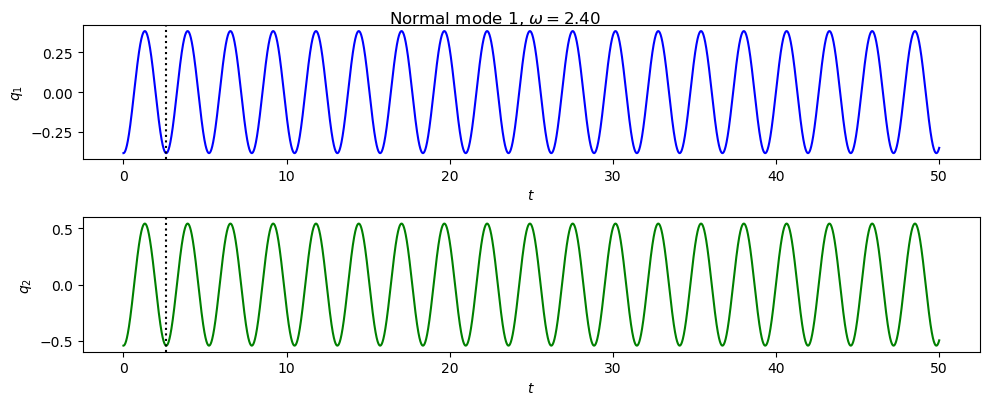

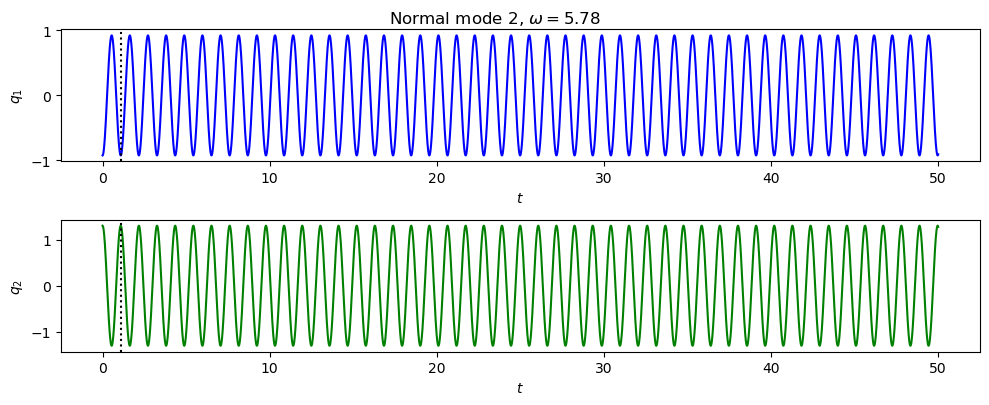

In [9]:
co1.plot_eigenmodes(t_pts)

[-0.38268343 -0.5411961 ] [ 3.74086267 -5.29037872]


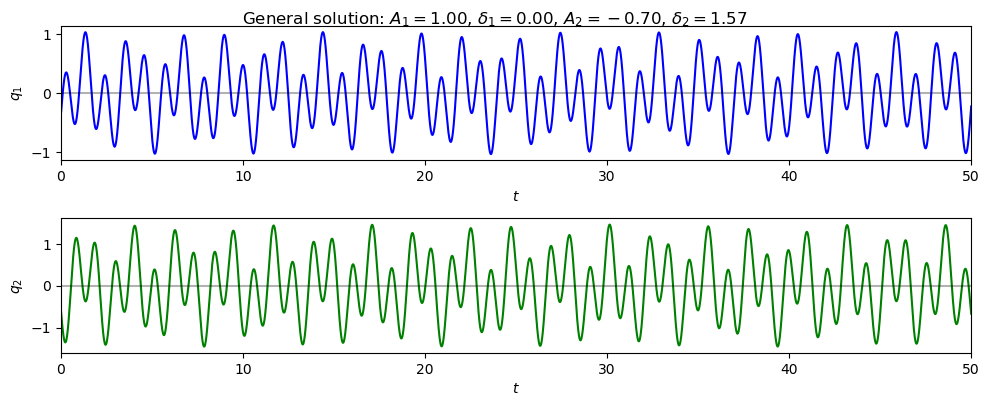

In [10]:
m1 = 8.
m2 = 2.
L1 = 5.
L2 = 3.
g = 10.

colors = ['blue', 'green', 'red', 'purple']

# changing A_i -> -A_i to match convention in Figure 11.6
A_1 = 1.
delta_1 = 0.
A_2 = -1
delta_2 = np.pi/2.

omega_1 = co1.frequencies[0]
omega_2 = co1.frequencies[1]

q_vec_0 = A_1 * eig_vecs[:,0] * np.cos(-delta_1) + \
          A_2 * eig_vecs[:,1] * np.cos(-delta_2)
q_vec_dot_0 = omega_1 * A_1 * eig_vecs[:,0] * np.sin(delta_1) + \
              omega_2 * A_2 * eig_vecs[:,1] * np.sin(delta_2)
q_vec_11p6, q_vec_dot_11p6 = co1.solve_ode(t_pts, q_vec_0, q_vec_dot_0)

fig, axes = plt.subplots(co1.q_len, 1, figsize=(10, 2.*co1.q_len))
for j in np.arange(co1.q_len):
    axes[j].plot(t_pts, q_vec_11p6[j], color=colors[j])
    axes[j].set_xlabel(r'$t$')
    axes[j].set_ylabel(fr'$q_{j+1:d}$')
    axes[j].set_xlim(t_pts[0], t_pts[-1])
    axes[j].axhline(0., color='black', alpha=0.3)
overall_title = 'General solution: ' + fr'$A_1 = {A_1:.2f}$, ' + \
                                       fr'$\delta_1 = {delta_1:.2f}$, ' + \
                                       fr'$A_2 = {A_2:.2f}$, ' + \
                                       fr'$\delta_2 = {delta_2:.2f}$'  
fig.suptitle(overall_title, va='center')
fig.tight_layout()


print( q_vec_0, q_vec_dot_0 )  # debugging check